# Lithium Hydride (LiH) Exemplar
## Step 0: Import various libraries

In [1]:
# Imports for QSCOUT
import jaqalpaq
from jaqalpaq.core import circuitbuilder
from jaqalpaq.core.circuit import normalize_native_gates
from jaqalpaq import emulator
from qscout.v1 import native_gates

# Imports for basic mathematical functionality
from math import pi
import numpy as np

# Imports for OpenFermion(-PySCF)
import openfermion as of
from openfermion.hamiltonians import MolecularData
from openfermionpyscf import run_pyscf
from openfermion.ops import QubitOperator
from openfermion.utils import eigenspectrum

# Import for VQE optimizer
from scipy import optimize

## Step 1: SCF calculation to assmble the second-quantized Hamiltonian

In [2]:
# Set the basis set, spin, and charge of the LiH molecule
basis = 'sto-6g'
multiplicity = 1
charge = 0

# Set calculation parameters
run_scf = 1
run_fci = 1
delete_input = True
delete_output = False

# Generate molecule at some bond length (1.4 Angstroms here)
geometry = [('Li', (0., 0., 0.)), ('H', (0., 0., 1.4))]
molecule = MolecularData(
    geometry, basis, multiplicity, charge,    
    filename='./LiH_sto-6g_single_1.4') #Set file location of data

# Run pyscf to generate new molecular data for sto-6g LiH
molecule = run_pyscf(molecule,
                     run_scf=run_scf,
                     run_fci=run_fci,
                     verbose=False)

print("Bond Length in Angstroms: {}".format(1.4))
print("FCI (Exact) energy in Hartrees: {}".format(molecule.fci_energy))

Bond Length in Angstroms: 1.4
FCI (Exact) energy in Hartrees: -7.968761975357028


## Step 2: Convert the fermionic Hamiltonian to a qubit Hamiltonian

In [3]:
# Get the fermionic Hamiltonian for LiH and map it using the BK encoding
# Reduce active space to orbitals 1, 2, and 3
hamiltonian = molecule.get_molecular_hamiltonian(occupied_indices=[0], active_indices=[1,2,3])
hamiltonian_ferm = of.get_fermion_operator(hamiltonian)
hamiltonian_bk = of.bravyi_kitaev(hamiltonian_ferm)

# Further reduce the Hamiltonian to 3 qubits
def reduce_hamiltonian(hamiltonian):
    terms = []
    cs = []
    for term in hamiltonian.terms:
        paulis = [None, None, None]
        ignore_term = False
        for pauli in term:
            #HF state |000001> {indices 7,6,5,4,3,2 -> 5,4,3,2,1,0}
            #Ansatz does not act on odd indices so they may be classically evaluated
            if pauli[0]%2==1 and (pauli[1]=='X' or pauli[1]=='Y'): #expectation value is 0
                ignore_term = True

            #Ansatz does act on even indices so they are left alone and relabled
            elif pauli[0]%2==0:
                paulis[pauli[0]//2] = pauli[1]
        if not ignore_term: #For terms that remain, separate out paulis and coefficients
            terms += [paulis]
            cs += [hamiltonian.terms[term]]
    
    #C ombine like terms in the Hamiltonian
    d = {}
    for i in range(len(terms)):
        if repr(terms[i]) in d: #If term is present...
            d[repr(terms[i])][1] += cs[i] #Sum coefficients for simplified pauli terms
        else: #If term isn't present...
            d[repr(terms[i])] = [terms[i], cs[i]] #Simply append it  
    return(list(d.values()))

# Reduce the BK Hamiltonian for LiH
terms = []
cs = []
red_hamiltonian_bk = QubitOperator()
result = reduce_hamiltonian(hamiltonian_bk)
for i in range(len(result)): #Separate out term and coeffs again after combining like terms
    terms += [result[i][0]]
    cs += [result[i][1]]
    string = ''
    for j, pauli in enumerate(result[i][0]):
        if pauli != None:
            string += str(pauli)+str(j)+' '
    red_hamiltonian_bk += result[i][1]*QubitOperator(string)

## Step 3: Define UCC Ansatz circuit in JaqalPaq

In [4]:
def ansatz(alpha, beta):
    term_probs = []
    for i in range(len(terms)):
        builder = circuitbuilder.CircuitBuilder(native_gates=normalize_native_gates(native_gates.NATIVE_GATES))
        
        # Define constants +-pi/2
        pi2 = builder.let('pi2', pi/2)
        npi2 = builder.let('npi2', -pi/2)
        
        # Create a qubit register
        q = builder.register('q', 3)
        
        # Define a hadamard macro
        hadamard = circuitbuilder.SequentialBlockBuilder()
        hadamard.gate('Sy', 'a')
        hadamard.gate('Px', 'a')
        builder.macro('hadamard', ['a'], hadamard)
        
        # Prepare the Hartree Fock state
        builder.gate('prepare_all')
        builder.gate('Px', q[0])
        builder.gate('Px', q[1])
        builder.gate('Px', q[2])
        
        # Apply the UCC Ansatz exp[-i*theta(X1 Y0)]
        builder.gate('MS', q[1], q[0], 0, pi2)
        builder.gate('Rz', q[0], alpha)
        builder.gate('MS', q[1], q[0], 0, npi2)

        builder.gate('MS', q[2], q[0], 0, pi2)
        builder.gate('Rz', q[0], beta)
        builder.gate('MS', q[2], q[0], 0, npi2)
        
        # Change basis for measurement depending on term
        for j, qubit in enumerate(terms[i]):
            if qubit == 'X':
                builder.gate('hadamard', ('array_item', q, j)),
            if qubit == 'Y':
                builder.gate('Sxd', ('array_item', q, j)),
        builder.gate('measure_all')
       
        circuit = builder.build()

        # Format results of simulation as a list of lists
        sim_result = emulator.run_jaqal_circuit(circuit)
        sim_probs = sim_result.subcircuits[0].probability_by_int
        probs = []
        for state in sim_probs:
            probs += [state] #Append probs of each state for a particular term
        term_probs += [probs] #Combine lists of probs of each term in Hamiltonian
    return term_probs

## Step 4: Define functions to calculate energy expectation value of Ansatz state

In [5]:
# Calculate energy of one term of the Hamiltonian for one possible state
def term_energy(term, state, coefficient, prob):
    parity = 1
    energy = 0
    for i in range(len(term)):
        if term[i] != None and state[i] == '1':
            parity = -1*parity
    energy = coefficient*prob*parity
    return energy

# Calculate energy of the molecule for given values of alpha and beta
def calculate_energy(params):
    energy = 0
    probs = ansatz(params[0], params[1]) #Convert tuple to float for circuit
    for i in range(len(terms)): #For each term in the hamiltonian
        for j in range(len(probs[0])): #For each possible state
            term = terms[i]
            state = '{0:03b}'.format(j)[::-1] #Formatted by number of qubits
            coefficient = cs[i].real
            prob = probs[i][j]
            energy += term_energy(term, state, coefficient, probs[i][j])
    return energy

## Step 5: Minimize the energy expectation value in α and ß

In [6]:
# Minimize the energy using classical optimization
optimize.minimize(fun=calculate_energy, x0=[0.01, 0.01], method="COBYLA")

     fun: -7.951823701263812
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 41
  status: 1
 success: True
       x: array([3.16713402, 3.21171031])

## Step 6: Loop over previous steps to calculate ground state energy at different bond lengths

In [7]:
# Set the basis set, spin, and charge of the LiH molecule
basis = 'sto-6g'
multiplicity = 1
charge = 0

# Set calculation parameters
run_scf = 1
run_fci = 1
delete_input = True
delete_output = False

optimized_energies = []
exact_energies = []

# Loop over bond lengths from 1.0 to 2.0 angstroms
n_pts = 11 #Number of points
bond_lengths = np.linspace(1.0,2.0,n_pts)
for diatomic_bond_length in bond_lengths:
    # Generate molecule at some bond length
    geometry = [('Li', (0., 0., 0.)), ('H', (0., 0., diatomic_bond_length))]
    molecule = MolecularData(
        geometry, basis, multiplicity, charge,
        description=str(round(diatomic_bond_length, 2)),
        filename='./LiH_sto-6g_single_dissociation')

    # Run pyscf
    molecule = run_pyscf(molecule,
                     run_scf=run_scf,
                     run_fci=run_fci,
                     verbose=False)
    
    # Get the fermionic Hamiltonian for LiH and map it using the BK encoding
    # Reduce active space to orbitals 1, 2, and 3
    hamiltonian = molecule.get_molecular_hamiltonian(occupied_indices=[0], active_indices=[1,2,3])
    hamiltonian_ferm = of.get_fermion_operator(hamiltonian)
    hamiltonian_bk = of.bravyi_kitaev(hamiltonian_ferm)
    
    # Reduce the BK Hamiltonian for LiH
    terms = []
    cs = []
    red_hamiltonian_bk = QubitOperator()
    result = reduce_hamiltonian(hamiltonian_bk)
    for i in range(len(result)): #Separate out term and coeffs again after combining like terms
        terms += [result[i][0]]
        cs += [result[i][1]]
        string = ''
        for j, pauli in enumerate(result[i][0]):
            if pauli != None:
                string += str(pauli)+str(j)+' '
        red_hamiltonian_bk += result[i][1]*QubitOperator(string)
    
    # Minimize the energy using classical optimization
    result = optimize.minimize(fun=calculate_energy, x0=[0.01, 0.01], method="COBYLA")
    optimized_energies.append(result.fun)
    exact_energies.append(eigenspectrum(red_hamiltonian_bk)[0])
    print("R={}\t Optimized Energy: {}".format(str(round(diatomic_bond_length, 2)), result.fun))

R=1.0	 Optimized Energy: -7.859672719729995
R=1.1	 Optimized Energy: -7.900779527942147
R=1.2	 Optimized Energy: -7.9273985237673354
R=1.3	 Optimized Energy: -7.943481713674375
R=1.4	 Optimized Energy: -7.951823702377698
R=1.5	 Optimized Energy: -7.954430873023549
R=1.6	 Optimized Energy: -7.952767359794153
R=1.7	 Optimized Energy: -7.9479184856511
R=1.8	 Optimized Energy: -7.940700223663853
R=1.9	 Optimized Energy: -7.931734039590466
R=2.0	 Optimized Energy: -7.921499494535991


## Step 7: Plot the dissociation curve

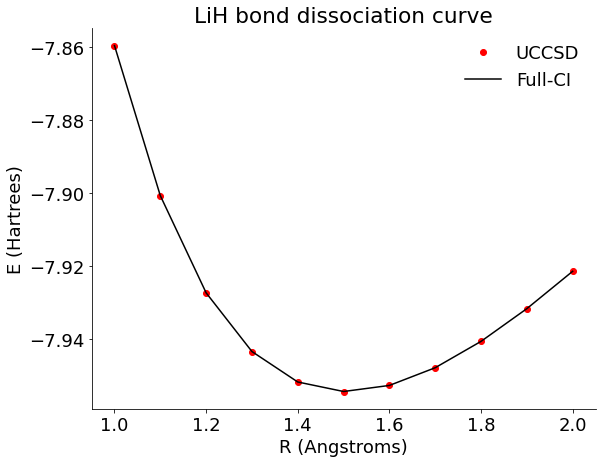

In [8]:
import matplotlib
import matplotlib.pyplot as pyplot

# Plot the various energies for different bond lengths
fig = pyplot.figure(figsize=(10,7))
pyplot.rcParams['font.size']=18
bkcolor = '#ffffff'
ax = fig.add_subplot(1, 1, 1)
pyplot.subplots_adjust(left=.2)
ax.set_xlabel('R (Angstroms)')
ax.set_ylabel(r'E (Hartrees)')
ax.set_title(r'LiH bond dissociation curve')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
bond_lengths = [float(x) for x in bond_lengths]
ax.plot(bond_lengths, optimized_energies, 'o', label='UCCSD', color='red')
ax.plot(bond_lengths, exact_energies, '-', label='Full-CI', color='black')

ax.legend(frameon=False)
pyplot.show()